# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np

from os.path import join
import json
import datetime

import time

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

## Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams

from src.feature_selection.functions import shap_feature_selection, process_fi

from src.utils.functions import adjust_fi

from src.model.functions import run_model_experiment

from src.plots.functions import plots_metrics

## Parameters

In [5]:
seed = 12345
iterations = 10
gamma = 0.146
n_estimators_list = [25, 50, 75, 100, 125, 150, 175, 200]
np.random.seed(seed)

dataset_id = 'mammography'
df = get_fs_dataset(dataset_id, data_root)
hyper = fs_datasets_hyperparams(dataset_id)

In [6]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,y
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0


### Paths

In [7]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")

## Features selected

### Generate/Load data

In [8]:
# Simulated data and settings
gamma, iterations = 0.146, 10

# Split the DataFrame into features (X) and target (y)
X = df.drop('y', axis=1)  # Features (all columns except 'y')
y = df['y']  # Target (the 'y' column)

# Split into training and testing sets
xtr, xte , ytr, yte = train_test_split(X, y, test_size=0.1, random_state=seed)

### Generate the model

In [9]:
# Initialize and train the IsolationForest model
model = IsolationForest(**hyper, random_state=seed)
model.fit(xtr)

IsolationForest(contamination=0.1, max_samples=256, random_state=12345)

### Features names

In [10]:
feature_names = np.array(X.columns.tolist())

### Selection process

In [11]:
# Example usage:
selected_features_df = shap_feature_selection(model, xtr, xte, feature_names, agnostic=False)
fi_shap_all = process_fi(selected_features_df, 10)
fi_shap_all.to_parquet(path_fi_shap)

In [12]:
fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all = adjust_fi(fi_shap_all)
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,2,1.129044,45.773293,33.333333,"[Col2, Col3]"
2,3,1.510599,61.242157,50.000000,"[Col2, Col3, Col6]"
3,4,1.883199,76.347960,66.666667,"[Col2, Col3, Col6, Col5]"
4,5,2.218425,89.938556,83.333333,"[Col2, Col3, Col6, Col5, Col1]"
5,6,2.466601,100.000000,100.000000,"[Col2, Col3, Col6, Col5, Col1, Col4]"


### Generate data

In [13]:
# Capture the start time
start_time = datetime.datetime.now()

results = run_model_experiment(fi_shap_all, df, hyper, 
                     gamma=gamma, iterations=iterations, 
                     n_estimators_list=n_estimators_list, seed=seed, 
                     dataset_id=dataset_id)

# Capture the finish time
finish_time = datetime.datetime.now()

# Calculate the duration
duration = finish_time - start_time

print(f"Duration: {duration}")

2024-09-01 21:26:56,568 - INFO - Starting experiment with 2 features.
2024-09-01 21:26:56,572 - INFO - Starting model training with 2 features and 25 estimators.
2024-09-01 21:27:03,333 - INFO - Starting model training with 2 features and 50 estimators.
2024-09-01 21:27:06,170 - INFO - Starting model training with 2 features and 75 estimators.
2024-09-01 21:27:10,226 - INFO - Starting model training with 2 features and 100 estimators.
2024-09-01 21:27:15,030 - INFO - Starting model training with 2 features and 125 estimators.
2024-09-01 21:27:21,330 - INFO - Starting model training with 2 features and 150 estimators.
2024-09-01 21:27:28,516 - INFO - Starting model training with 2 features and 175 estimators.
2024-09-01 21:27:36,747 - INFO - Starting model training with 2 features and 200 estimators.
2024-09-01 21:27:46,038 - INFO - Starting experiment with 3 features.
2024-09-01 21:27:46,040 - INFO - Starting model training with 3 features and 25 estimators.
2024-09-01 21:27:47,643 - I

Duration: 0:04:38.849686


In [14]:
results.to_parquet(path_shap)

In [15]:
df = pd.read_parquet(path_shap)

2024-09-01 21:32:13,997 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-01 21:32:14,024 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-01 21:32:14,148 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-01 21:32:14,177 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-09-01 21:32:14,292 - INFO - Using categorical units to plot a list of strings that are all parsable as 

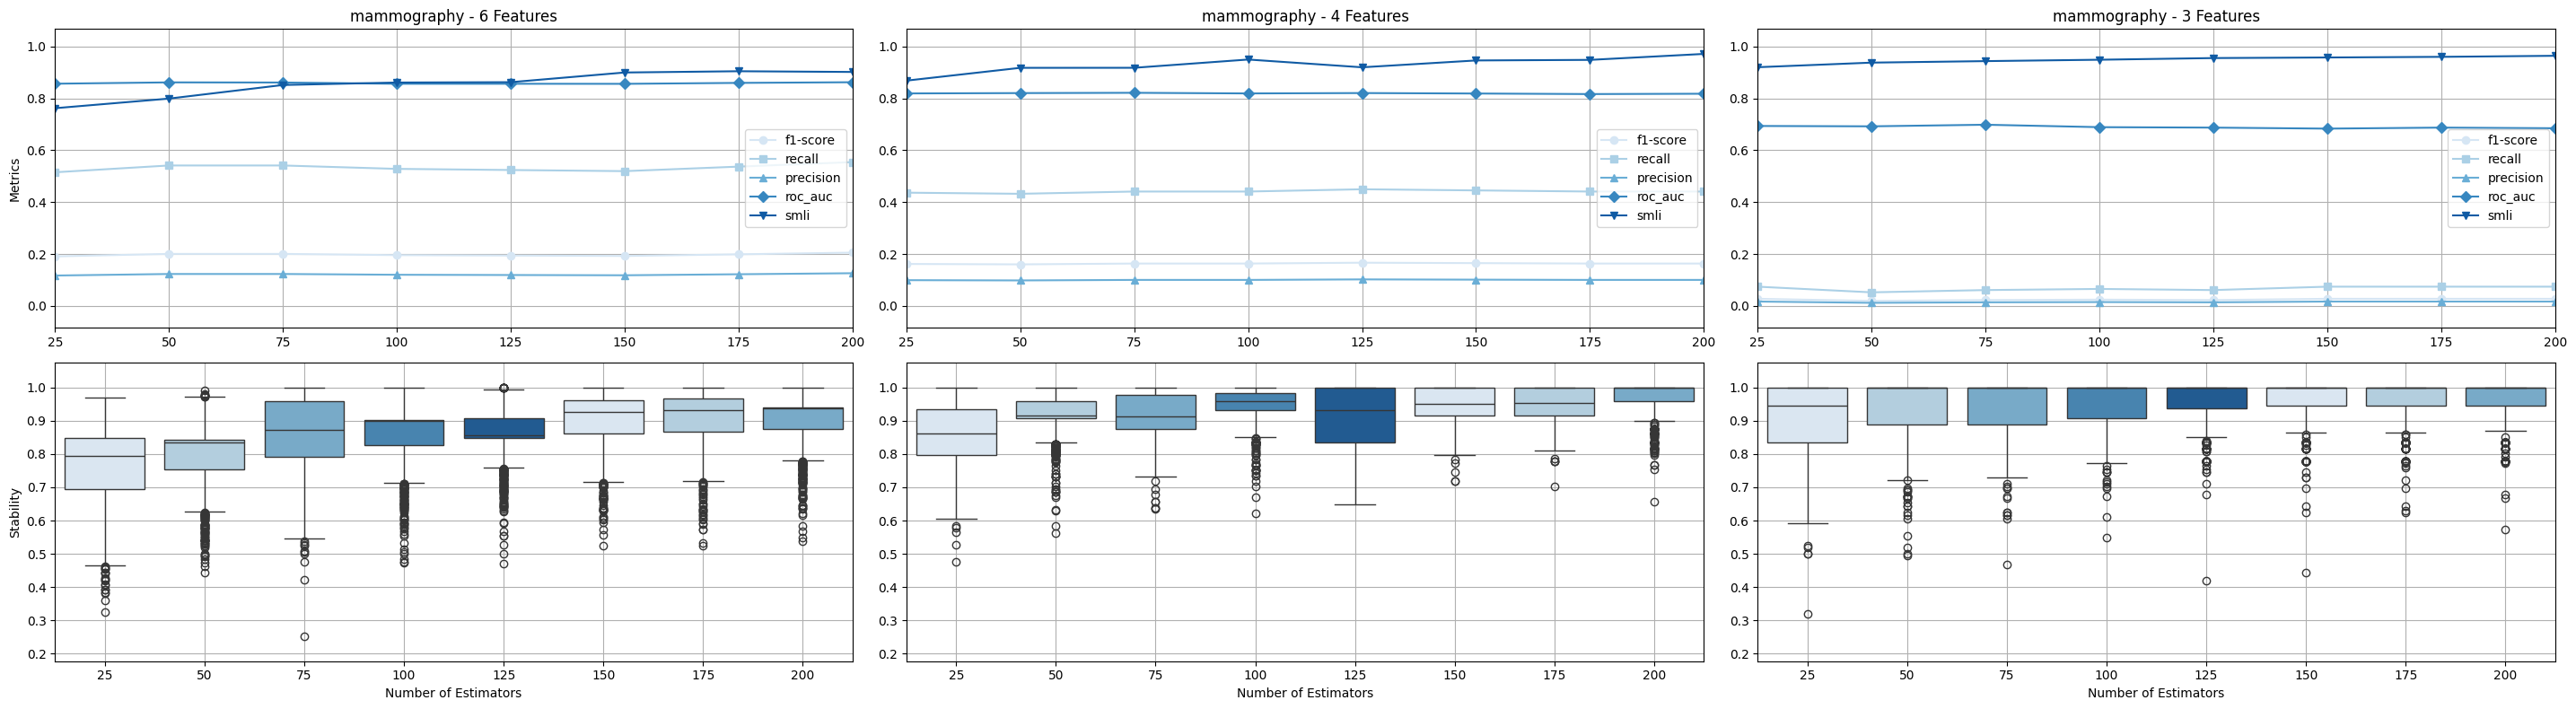

In [18]:
plots_metrics(
    metrics_df=df,
    dataset_id=dataset_id,
    feat_imp=[100, 80, 60],
    metrics_list=['f1-score', 'recall', 'precision', 'roc_auc', 'smli', 'smli_all'],
    metrics_merge_list=['f1-score', 'precision', 'recall', 'roc_auc', 'smli']
)